#Importing Dataset and Libraries

In [0]:
#Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Unzip the dataset
!unzip -q "/content/drive/My Drive/Colab Datasets/train.zip"

In [0]:
#Importing the dataset
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import time
from scipy.stats import skew

In [0]:
#Set the training data to a variable 

%time trainData = pq.read_pandas("train.parquet", columns=[str(i+5805) for i in range(2904)]).to_pandas()


In [0]:
#Plotting the signal **make sure to give it a title

def plotRaw(signal , title, signalfit = False, signaltype=0):
  plt.figure(figsize=(10, 5), dpi = 150)
  ax = plt.axes()
  ax.set_facecolor("white")
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('3')  
  plt.plot(signal)
  plt.title(title)


# Preprocessing

Importing functions relevant to preprocess our data

In [0]:
#Some Functions were referenced from another Kaggle Notebook at https://www.kaggle.com/jeffreyegan/vsb-power-line-fault-detection-approach 

#Importing Relevant Libraries
import pywt
from statsmodels.robust import mad
from scipy import signal
from scipy.optimize import leastsq 

## Discrete Wavelet Transform 
def waveletSmooth(x, wavelet="db4", level=1): 
    coeff = pywt.wavedec( x, wavelet, mode="per")
    # print(coeff[-level].size)
    sigma = mad(coeff[-level])
    # print(sigma)
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    # print(uthresh)
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:])
    y = pywt.waverec( coeff, wavelet, mode="per")
    y = np.round(y,3)
    return y


## Detrending by getting the Derivative 
def detrend_signal(signal):
    x = np.diff(signal, n=1)
    x = np.append(x,x[799998])
    return x


## Calculating statistic features 
def calculate_statistics(signal):
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    skewness = skew(signal) 
    return [ median, mean, std, var,skewness]





## Running Detrend Algorithm

Detrending done to all the dataset so that we can perform feature extraction, this was done in multiple steps because the file we were working with is too big!!

In [0]:
#Initialized Denoised Files (This was done 3 times)
n = 7260
%time trainData = pq.read_pandas("/content/drive/My Drive/Downloads/df3.parquet", columns=[str(i+n) for i in range(1452)]).to_pandas()

In [0]:
start = time.time()
for i in range(1452):
  trainData[str(i+n)]=detrend_signal(trainData[str(i+n)])
elapsed_time_fl = (time.time() - start) 
print(elapsed_time_fl)

In [0]:
dt32.to_parquet('dt32.parquet') 
!cp dt32.parquet "/content/drive/My Drive/Downloads"
!ls "/content/drive/My Drive/Downloads"

## Preprocessing Results

In [0]:
trainData = pq.read_pandas("/content/drive/My Drive/Downloads/temp.parquet", columns=["8"]).to_pandas()

In [0]:
rawSig = trainData["8"]
dnSig = waveletSmooth(rawSig) #Denoised Signal

13
13
25
49
98
196
391
782
1563
3125
6250
12500
25000
50000
100000
200000
400000


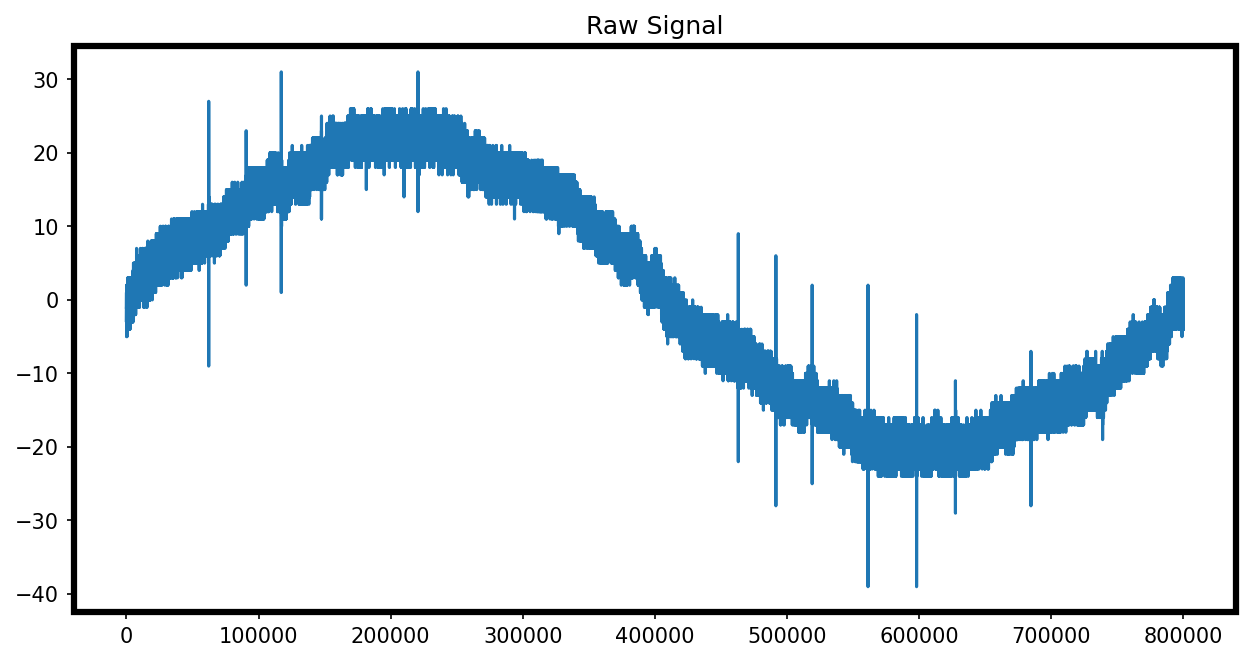

In [0]:
rawSig = trainData["8"]
dnSig = waveletSmooth(rawSig) #Denoised Signal
dtSig = detrend_signal(dnSig)

# Ploting Signals all signals from raw to detrended peaks that is just denoised
plotRaw(rawSig,"Raw Signal")



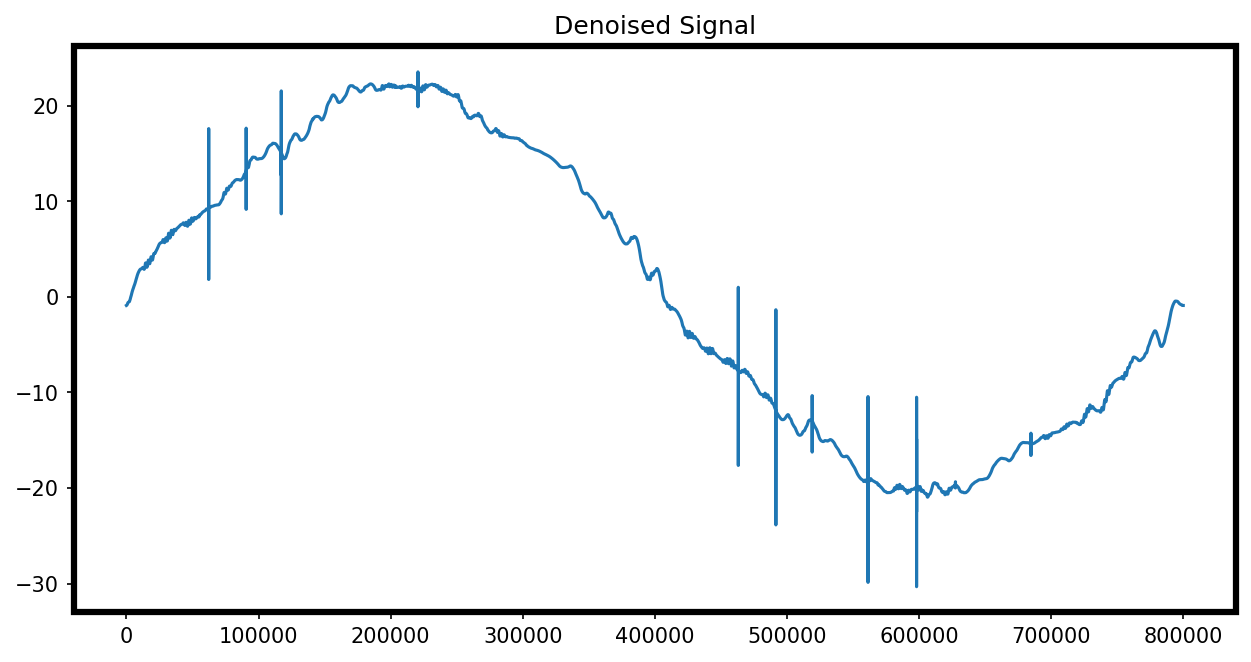

In [0]:
plotRaw(dnSig,"Denoised Signal")


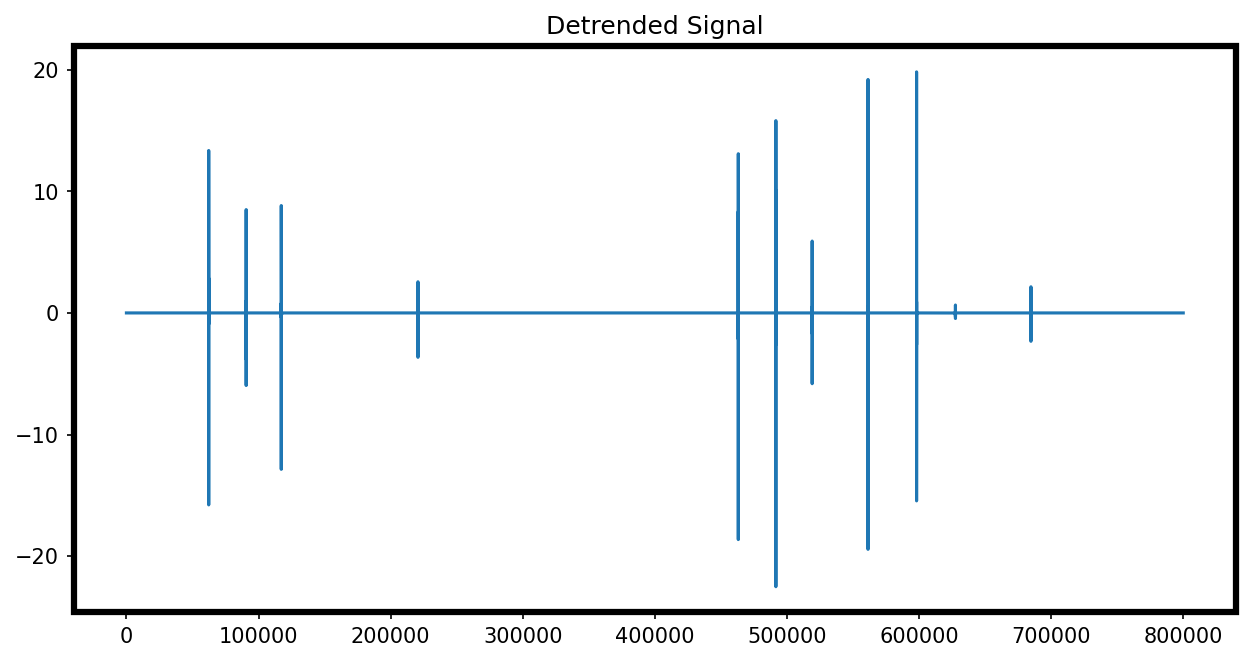

In [0]:
plotRaw(dtSig,"Detrended Signal")


# Feature Extraction

After Detrending the goal is to only take the relevant signals.
This includes the 525 PD-Signals and 1050 Healthy Signals

In [0]:
#Adding peak extraction functions, code was referenced from  https://www.kaggle.com/jeffreyegan/vsb-power-line-fault-detection-approach 

## Finding peaks of the signal 
def find_peaks(signal):
    thresh = 4.0  
    min_d = 0
    peaks = np.argwhere(signal > thresh)
    peakCount = len(peaks)
    valleys = np.array(np.argwhere(signal < -thresh))
    valCount = len(valleys)
    pois = np.sort(np.concatenate((peaks, valleys)))
    peak_indexes = []
    for pk in pois:
        peak_indexes.append(pk[0])
    return np.sort(peak_indexes),peakCount,valCount

## Calculate width of peaks  
def calculate_peak_widths(peak_idxs):
    tmp_w = 1
    widths = []
    for idx in range(1,len(peak_idxs)):
        if peak_idxs[idx]-peak_idxs[idx-1] < 3:
            tmp_w +=1
        else:
            widths.append(tmp_w)
            tmp_w = 1
    widths.append(tmp_w)
    min_width = min(np.array(widths))
    max_width = max(np.array(widths))
    mean_width = np.nanmean(np.array(widths))
    num_true_peaks = len(widths)
    return min_width, max_width, mean_width, num_true_peaks

## Get total peak values
def calculate_peaks(signal, true_peak_indexes):  
    num_detect_peak = len(true_peak_indexes)
    if num_detect_peak > 0:
        peak_values = signal[true_peak_indexes]
        min_height = min(peak_values)
        max_height = max(peak_values)
        max_diff = max_height - min_height
        mean_height = np.nanmean(peak_values)
        min_width, max_width, mean_width, num_true_peaks = calculate_peak_widths(true_peak_indexes)
        return [min_height, max_height,max_diff, mean_height, min_width, max_width, mean_width, num_detect_peak, num_true_peaks]
    else:
        return [0, 0, 0, 0, 0, 0, 0, 0,0]


In [0]:
#Checking to see all the indices of the the signal from above

peak_idx, pkCount,valCount = find_peaks(dtSig)
print(peak_idx)
print("Count of Peaks: " ,pkCount)
print("Count of Valleys: ", valCount)

[ 62286  62287  62288  62289  90646  90647 117219 117220 117221 463187
 463188 463189 491613 491614 491615 519106 519107 519108 561384 561385
 561386 561387 598130 598131 598132 598133]
Count of Peaks:  15
Count of Valleys:  11


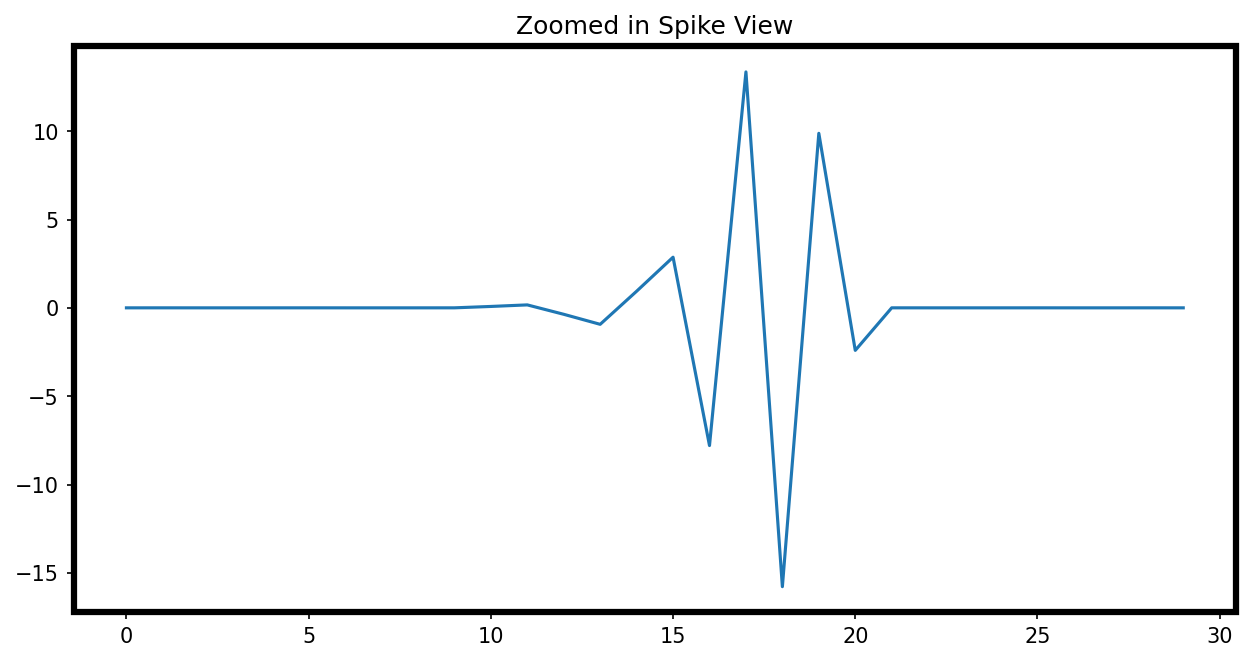

In [0]:
#Plotting zoomed in view
plotRaw(dtSig[62270:62300],"Zoomed in Spike View")

##Creating Features for PD Signals

Extract all signals that were labeled with a Partial Discharge
Extracting features for all the signals with Partial Discharges and appending it into one dataset .csv file (trueFeats.csv)


In [0]:
#Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')


In [0]:
#Import all indexes with PD signals

import csv
truelabels = []
with open("/content/drive/My Drive/Downloads/truelabels.csv", 'r') as file:
    next(file)
    csvreader  = csv.reader(file)
    for row in csvreader:
      truelabels.append(row[0])

In [0]:
#Extract signals from different files

n = 1452
trueData = pd.DataFrame(np.array([]))
for labels in truelabels:
  if int(labels) < n:
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt11.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n) and (int(labels) < (n*2)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt12.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*2) and (int(labels) < (n*3)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt21.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*3) and (int(labels) < (n*4)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt22.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*4) and (int(labels) < (n*5)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt31.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*5) and (int(labels) < (n*6)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt32.parquet", columns=[str(labels)]).to_pandas()
  trueData = pd.concat([trueData,trainData],axis=1)
trueData.columns = trueData.columns.map(str)

In [0]:
#
%time trueData = pq.read_pandas("/content/drive/My Drive/Downloads/dfTrue.parquet").to_pandas()
print(trueData)

CPU times: user 3.8 s, sys: 21.8 s, total: 25.6 s
Wall time: 51.8 s
            3      4      5    201    202  ...   8483   8568  8569   8570   8630
0      -0.057 -0.088 -0.009  0.001 -0.001  ... -0.073  0.000   0.0  0.001  0.000
1      -0.072 -0.113 -0.010  0.000  0.000  ... -0.081  0.000   0.0  0.001  0.000
2      -0.045 -0.054 -0.008  0.000  0.000  ... -0.065  0.000   0.0  0.001  0.000
3      -0.018  0.008 -0.005  0.000  0.000  ... -0.045  0.000   0.0  0.001  0.000
4      -0.007  0.035 -0.004  0.000 -0.001  ... -0.040  0.000   0.0  0.002 -0.001
...       ...    ...    ...    ...    ...  ...    ...    ...   ...    ...    ...
799995 -0.006  0.006 -0.004  0.000  0.000  ... -0.035  0.000   0.0  0.002  0.000
799996 -0.019 -0.014 -0.006  0.000  0.000  ... -0.037  0.000   0.0  0.001  0.000
799997 -0.042 -0.052 -0.008  0.000 -0.001  ... -0.035 -0.001   0.0  0.001  0.000
799998 -0.041 -0.053 -0.007  0.000  0.000  ... -0.051  0.000   0.0  0.001  0.000
799999 -0.041 -0.053 -0.007  0.000  0.000

In [0]:
#Create a flat-list with a the features to create a dataset with all trueLabel

trueFeats = []
for cols in trueCols:
  flat_list = []
  lsCombined = []
  ls1 = []
  ls2 = []
  ls3 = []
  
  arr = trueData[cols].to_numpy()
  
  stats = calculate_statistics(arr)
  peak_idx, pkCount,valCount = find_peaks(arr)
  feats = calculate_peaks(arr,peak_idx)

  ls1.append([cols,pkCount,valCount])
  ls2.append(stats) 
  ls3.append(feats)

  lsCombined = ls1 + ls2 + ls3
  flat_list = [item for sublist in lsCombined for item in sublist]
  trueFeats.append(flat_list)


In [0]:
colNames = ["signalID","peakCount","valCount","median","mean","std","var","skewness","minHeight", "maxHeight", "heightDiff","meanHeight", "minWidth", "maxWidth", "meanWidth", "numTotSpikes", "numTrueSpikes"]
dfTrue =pd.DataFrame(trueFeats, columns=colNames)
dfTrue.insert(17,"fault",1,True)

In [0]:
from google.colab import files
dfTrue.to_csv('trueFeats.csv') 
!cp trueFeats.csv "/content/drive/My Drive/Downloads"
!ls "/content/drive/My Drive/Downloads" 

## Getting 1050 Healthy Signals for Dataset

Doing the same thing as above, we are choosing 1050 random signals out of the 8712 signals and exporting it as a .csv file (randFeats.csv)


In [0]:
import random
random.seed(351)
lsRand = random.sample(range(8712), 1050)
print(lsRand)


[5680, 5277, 4450, 5228, 4844, 7485, 6370, 3587, 6560, 7664, 3785, 4495, 4369, 4142, 5640, 7888, 1455, 8270, 527, 4355, 7145, 3481, 2001, 8186, 4435, 2313, 2673, 5568, 1984, 3438, 6908, 4846, 3084, 6006, 8226, 2714, 237, 3323, 2554, 2531, 1029, 1296, 4032, 8116, 7631, 4214, 6372, 824, 2588, 6499, 4327, 4986, 8547, 4094, 6755, 4864, 3044, 1165, 3670, 8332, 3916, 2014, 5178, 4791, 3463, 6495, 4785, 8200, 5045, 148, 1664, 3326, 4052, 761, 5364, 7557, 7429, 516, 3317, 3715, 5842, 3722, 854, 7286, 3273, 8587, 754, 7163, 4634, 6308, 2991, 2279, 2258, 6252, 7964, 7029, 2937, 8473, 4872, 3677, 4099, 7875, 5814, 1392, 7727, 7236, 3713, 3294, 1219, 6138, 1054, 2637, 4630, 5607, 2431, 2335, 4918, 5240, 2922, 2753, 4942, 3342, 253, 1988, 7109, 6317, 4954, 641, 8190, 5968, 3450, 751, 2692, 6639, 2395, 3724, 4159, 5300, 2570, 7852, 1921, 8561, 8579, 5878, 7067, 2942, 5697, 906, 852, 5758, 6563, 5078, 1982, 3798, 7788, 747, 1826, 182, 1723, 8346, 447, 6990, 634, 2909, 1436, 1936, 551, 2334, 2115, 815

In [0]:
n = 1452
i = 0
lsRandData = pd.DataFrame(np.array([]))
for labels in lsRand:
  print(i)
  if int(labels) < n:
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt11.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n) and (int(labels) < (n*2)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt12.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*2) and (int(labels) < (n*3)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt21.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*3) and (int(labels) < (n*4)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt22.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*4) and (int(labels) < (n*5)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt31.parquet", columns=[str(labels)]).to_pandas()
  if (int(labels) >= n*5) and (int(labels) < (n*6)):
    trainData = pq.read_pandas("/content/drive/My Drive/Downloads/dt32.parquet", columns=[str(labels)]).to_pandas()
  lsRandData = pd.concat([lsRandData,trainData],axis=1)
  i=i+1
lsRandData.columns = lsRandData.columns.map(str)


In [0]:
trueFeats = []
for cols in dt11:
  flat_list = []
  lsCombined = []
  ls1 = []
  ls2 = []
  ls3 = []
  
  arr = dt11[cols].to_numpy()
  
  stats = calculate_statistics(arr)
  peak_idx, pkCount,valCount = find_peaks(arr)
  feats = calculate_peaks(arr,peak_idx)

  ls1.append([cols,pkCount,valCount])
  ls2.append(stats) 
  ls3.append(feats)

  lsCombined = ls1 + ls2 + ls3
  flat_list = [item for sublist in lsCombined for item in sublist]
  trueFeats.append(flat_list)


colNames = ["signalID","peakCount","valCount","median","mean","std","var","skewness","minHeight", "maxHeight", "heightDiff","meanHeight", "minWidth", "maxWidth", "meanWidth", "numTotSpikes", "numTrueSpikes"]
dfTrue =pd.DataFrame(trueFeats, columns=colNames)
dfTrue.insert(17,"fault",0,True)


In [0]:
from google.colab import files
dfTrue.to_csv('randFeats.csv') 
!cp trueFeats.csv "/content/drive/My Drive/Downloads"
!ls "/content/drive/My Drive/Downloads" 

# Machine Learning Classification Models

In this section we will be training and testing a Machine Learning classification model. Classifiers that are used include Random Forest Classifier (RF), Support Vector Machine (SVM), LightGBM (LGBM) and Logistic Regression (LR)

## Importing Libraries and Dataset

In [0]:
#Import Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Import Libraries for Machine Learning Models

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import plot_confusion_matrix
from statistics import mean

import seaborn as sns


In [0]:
#Importing csv files
trueFeats = pd.read_csv("/content/drive/My Drive/Downloads/trueFeats.csv")
randFeats = pd.read_csv("/content/drive/My Drive/Downloads/randFeats.csv")

#Combining dataframes
df = pd.concat([trueFeats, randFeats], ignore_index=True)
df['signalID'] = df['signalID'].astype(int)
df = df.sort_values(by=['signalID'])

print(df)

#Deleting Unnecessary Columns
del df["Unnamed: 0"]
del df["signalID"]

print(df)

      Unnamed: 0  signalID  peakCount  ...  numTotSpikes  numTrueSpikes  fault
937          412         1         18  ...            35             16      0
0              0         3        328  ...           629            204      1
1              1         4        141  ...           256             94      1
2              2         5        352  ...           725            216      1
1497         972        11       2707  ...          5443            741      0
...          ...       ...        ...  ...           ...            ...    ...
1496         971      8676          0  ...             0              0      0
1150         625      8683         86  ...           179             53      0
1570        1045      8688        147  ...           312             89      0
1358         833      8695         13  ...            22             11      0
1247         722      8698       2367  ...          4744            834      0

[1574 rows x 19 columns]
      peakCount  valCount 

## Classfier Pipeline Function

In [0]:
#Classifier that has 5-fold stratified cross validation
def model(df,classifer,title):
  #Splitting up X and Y

  print(df)
  X = df.iloc[:,0:-1]
  X = X.values
  y = df.iloc[:,-1:]
  y = y.values

  listPrecision = []
  listRecall = []
  listAuc = []
  listF1 = []
  listCM = []
  listMCC = []

  countFold = 1

  cv = StratifiedKFold(n_splits=5, random_state = 351)
  for train_idx, test_idx, in cv.split(X,y):    
    
    print("Running fold:", countFold)
    X_train, X_test = X[train_idx,:], X[test_idx,:] 
    y_train, y_test = y[train_idx,:], y[test_idx,:]

    clf = classifer
    
    model = Pipeline([('RF', clf)])
    model.set_params(RF__random_state=351).fit(X_train, y_train.ravel())

    y_pred = model.predict(X_test)


    precision = precision_score(y_test, y_pred) #scores for random forest model
    listPrecision.append(round(precision,5))
    recall = recall_score(y_test, y_pred)
    listRecall.append(round(recall,5))
    auc = roc_auc_score(y_test,y_pred)
    listAuc.append(round(auc,5))
    f1 = f1_score(y_test,y_pred)
    listF1.append(round(f1,5))
    mcc = matthews_corrcoef(y_test,y_pred)
    listMCC.append(round(mcc,5))


    cm = confusion_matrix(y_test,y_pred)   
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print('Classification report \n {} \n'.format(classification_report(y_test, y_pred)))
    print("Confusion Matrix: ", cm)

    ax = plt.subplot()
    sns.set(font_scale=2) 
    sns.heatmap(cmn, annot=True, ax=ax, cmap="Blues", fmt=".2g");  

    
    label_font = {'size':'20'}  
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('True labels', fontdict=label_font);


    ax.tick_params(axis='both', which='major', labelsize=16) 
    ax.xaxis.set_ticklabels(['Non-PD', 'PD']);
    ax.yaxis.set_ticklabels(['Non-PD', 'PD']);
    plt.show()
    countFold = countFold+1

  

  print(title + " Precision Score: ",listPrecision , " |Average Precision Score: ", mean(listPrecision))
  print(title + " Recall Score: ",listRecall,  " |Average Recall Score: ", mean(listRecall))
  print(title + " AUC Score: ",listAuc,  " |Average AUC Score: ", mean(listAuc))
  print(title + " F1 Score: ",listF1,  " |Average F1 Score: ", mean(listF1))
  print(title + " MCC Score: ",listMCC,  " |Average MCC Score: ", mean(listMCC))
  
  return clf

## Random Forest Classifier (Baseline Model/Pre-Feature Engineering)

      peakCount  valCount  median  ...  numTotSpikes  numTrueSpikes  fault
937          18        17     0.0  ...            35             16      0
0           328       301     0.0  ...           629            204      1
1           141       115     0.0  ...           256             94      1
2           352       373     0.0  ...           725            216      1
1497       2707      2736     0.0  ...          5443            741      0
...         ...       ...     ...  ...           ...            ...    ...
1496          0         0     0.0  ...             0              0      0
1150         86        93     0.0  ...           179             53      0
1570        147       165     0.0  ...           312             89      0
1358         13         9     0.0  ...            22             11      0
1247       2367      2377     0.0  ...          4744            834      0

[1574 rows x 17 columns]
Running fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Classification report 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       195
           1       0.89      0.71      0.79       120

    accuracy                           0.85       315
   macro avg       0.86      0.83      0.84       315
weighted avg       0.86      0.85      0.85       315
 

Confusion Matrix:  [[184  11]
 [ 35  85]]


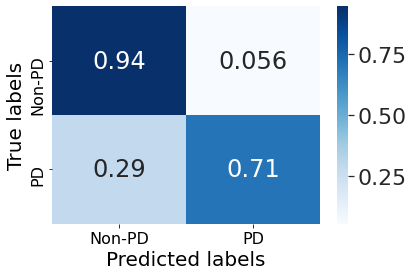

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       195
           1       0.80      0.78      0.79       120

    accuracy                           0.84       315
   macro avg       0.83      0.83      0.83       315
weighted avg       0.84      0.84      0.84       315
 

Confusion Matrix:  [[171  24]
 [ 26  94]]


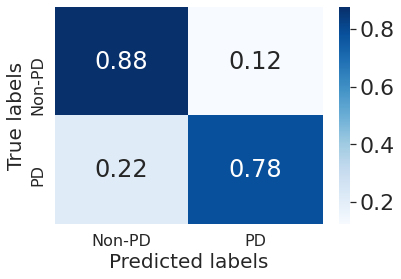

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       195
           1       0.77      0.79      0.78       120

    accuracy                           0.83       315
   macro avg       0.82      0.82      0.82       315
weighted avg       0.83      0.83      0.83       315
 

Confusion Matrix:  [[167  28]
 [ 25  95]]


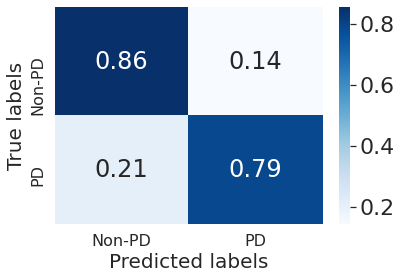

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       195
           1       0.81      0.73      0.77       120

    accuracy                           0.83       315
   macro avg       0.83      0.82      0.82       315
weighted avg       0.83      0.83      0.83       315
 

Confusion Matrix:  [[175  20]
 [ 32  88]]


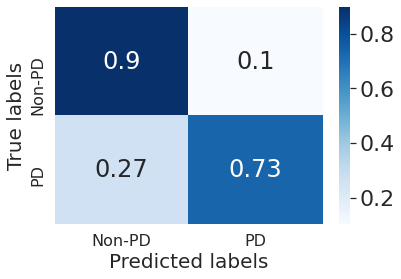

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       194
           1       0.81      0.72      0.76       120

    accuracy                           0.83       314
   macro avg       0.82      0.81      0.81       314
weighted avg       0.83      0.83      0.83       314
 

Confusion Matrix:  [[173  21]
 [ 33  87]]


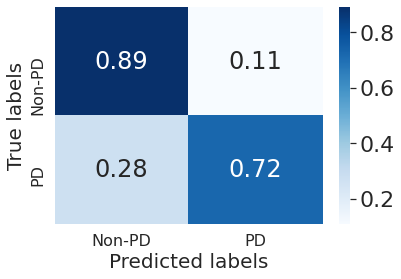

Random Forest Precision Score:  [0.88542, 0.79661, 0.77236, 0.81481, 0.80556]  |Average Precision Score:  0.814952
Random Forest Recall Score:  [0.70833, 0.78333, 0.79167, 0.73333, 0.725]  |Average Recall Score:  0.748332
Random Forest AUC Score:  [0.82596, 0.83013, 0.82404, 0.81538, 0.80838]  |Average AUC Score:  0.820778
Random Forest F1 Score:  [0.78704, 0.78992, 0.78189, 0.77193, 0.76316]  |Average F1 Score:  0.7787879999999999
Random Forest MCC Score:  [0.68778, 0.66244, 0.64511, 0.64533, 0.63089]  |Average MCC Score:  0.65431


In [0]:
clfBL = model(df,RandomForestClassifier(random_state=351),"Random Forest")


## Feature Selection

This section we checked for importance using the results taken from the random forest classifier. We also checked for multicollinearity using the pearson correlation coefficient

In [0]:
# Output Feature Importance using Random Forest

colNames2 = ["peakCount","valCount","median","mean","std","var","skewness","minHeight", "maxHeight", "heightDiff","meanHeight", "minWidth", "maxWidth", "meanWidth", "numTotSpikes", "numTrueSpikes"]
feature_importances = pd.DataFrame(clfBL.feature_importances_,
                                   index = colNames2,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

               importance
numTrueSpikes    0.139764
meanWidth        0.110505
peakCount        0.096083
numTotSpikes     0.090307
valCount         0.078638
maxWidth         0.076349
minHeight        0.065060
var              0.061029
std              0.058628
maxHeight        0.057655
heightDiff       0.056406
skewness         0.046591
meanHeight       0.042198
median           0.016261
mean             0.003917
minWidth         0.000610


               peakCount  valCount  ...  numTrueSpikes     fault
peakCount       1.000000  0.999935  ...       0.947299  0.219893
valCount        0.999935  1.000000  ...       0.947644  0.220575
median         -0.003270 -0.003282  ...      -0.003165 -0.033152
mean            0.044218  0.043316  ...       0.020090  0.002457
std             0.863111  0.862499  ...       0.763487  0.156829
var             0.897692  0.896895  ...       0.745328  0.107194
skewness        0.016168  0.016352  ...       0.015794 -0.051352
minHeight      -0.542176 -0.542023  ...      -0.509129 -0.183692
maxHeight       0.538014  0.537896  ...       0.501922  0.162769
heightDiff      0.542649  0.542513  ...       0.507913  0.174032
meanHeight     -0.012705 -0.013646  ...      -0.013801 -0.054317
minWidth        0.084091  0.084077  ...       0.092369  0.175843
maxWidth        0.628545  0.627279  ...       0.481868 -0.010741
meanWidth       0.438595  0.438086  ...       0.327253  0.078827
numTotSpikes    0.999984 

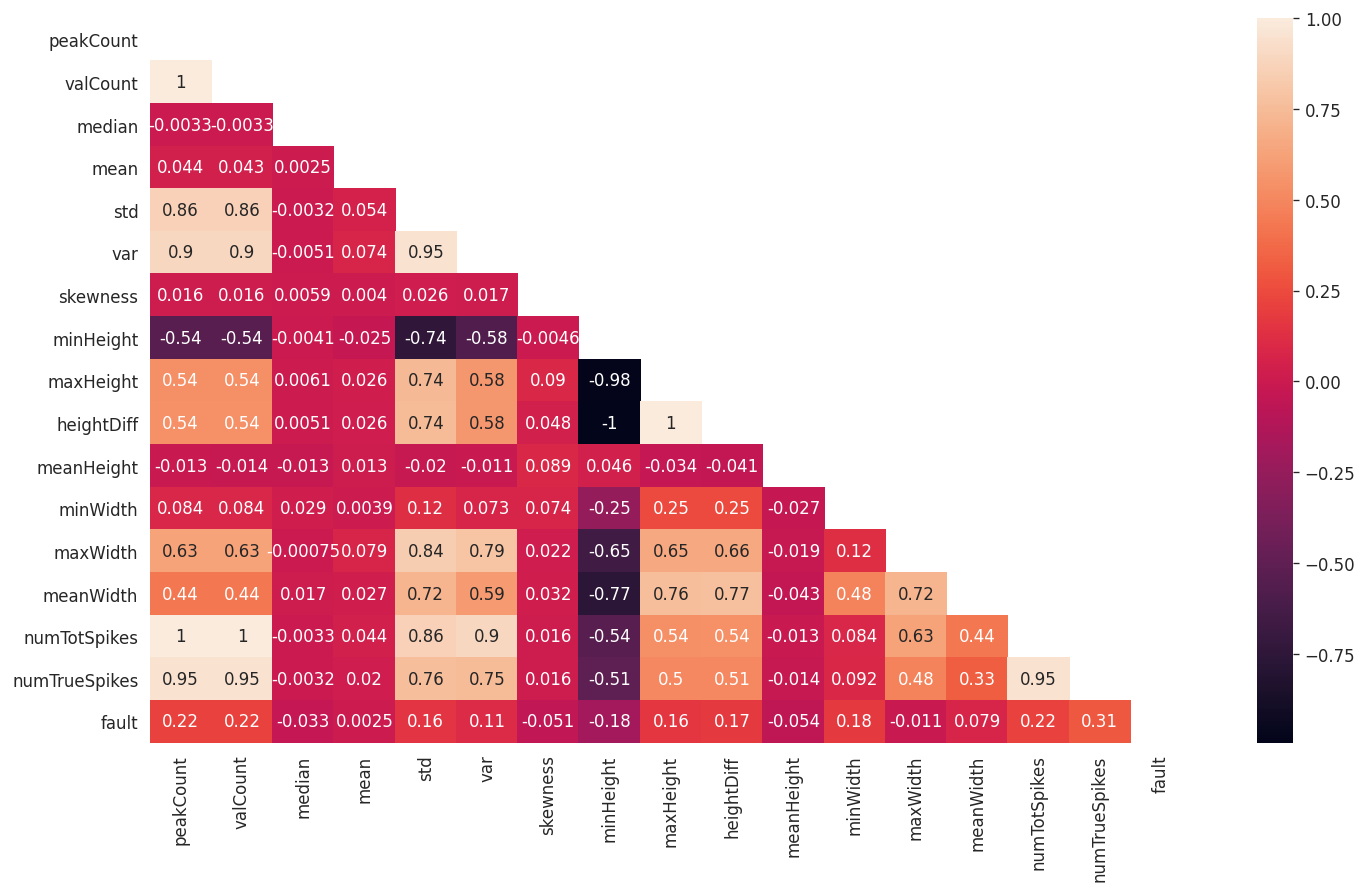

In [0]:

corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
   ax = sns.heatmap(corr, mask=mask,annot=True)
    
print(corr)

## Random Forest (Post-Feature Selection) 

In [0]:
#Removing features due to multicollinearity and low importance scores 

dfAfter = df.copy()
print(df)

del dfAfter["maxHeight"]
del dfAfter["heightDiff"]
del dfAfter["peakCount"]
del dfAfter["valCount"]
del dfAfter["numTotSpikes"]
del dfAfter["std"]
del dfAfter["minWidth"]
del dfAfter["mean"]

print(dfAfter)

      peakCount  valCount  median  ...  numTotSpikes  numTrueSpikes  fault
937          18        17     0.0  ...            35             16      0
0           328       301     0.0  ...           629            204      1
1           141       115     0.0  ...           256             94      1
2           352       373     0.0  ...           725            216      1
1497       2707      2736     0.0  ...          5443            741      0
...         ...       ...     ...  ...           ...            ...    ...
1496          0         0     0.0  ...             0              0      0
1150         86        93     0.0  ...           179             53      0
1570        147       165     0.0  ...           312             89      0
1358         13         9     0.0  ...            22             11      0
1247       2367      2377     0.0  ...          4744            834      0

[1574 rows x 17 columns]
      median        var    skewness  ...  meanWidth  numTrueSpikes  fault


      median        var    skewness  ...  meanWidth  numTrueSpikes  fault
937      0.0   0.003133  -17.435420  ...   2.187500             16      0
0        0.0   0.242051   -9.929521  ...   3.083333            204      1
1        0.0   0.036587   -9.210680  ...   2.723404             94      1
2        0.0   0.258717    2.670135  ...   3.356481            216      1
1497     0.0  15.313045   -0.226941  ...   7.345479            741      0
...      ...        ...         ...  ...        ...            ...    ...
1496     0.0   0.001693   -0.035624  ...   0.000000              0      0
1150     0.0   0.117272  -20.642137  ...   3.377358             53      0
1570     0.0   0.548200   19.221711  ...   3.505618             89      0
1358     0.0   0.002997 -113.751897  ...   2.000000             11      0
1247     0.0   3.474154   -2.169522  ...   5.688249            834      0

[1574 rows x 9 columns]
Running fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Classification report 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       195
           1       0.85      0.67      0.75       120

    accuracy                           0.83       315
   macro avg       0.84      0.80      0.81       315
weighted avg       0.83      0.83      0.82       315
 

Confusion Matrix:  [[181  14]
 [ 40  80]]


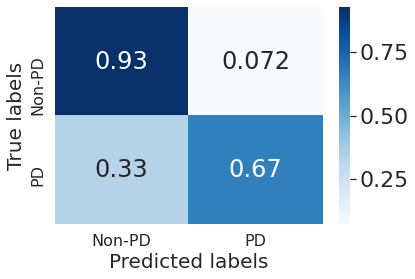

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       195
           1       0.82      0.78      0.80       120

    accuracy                           0.85       315
   macro avg       0.84      0.84      0.84       315
weighted avg       0.85      0.85      0.85       315
 

Confusion Matrix:  [[175  20]
 [ 27  93]]


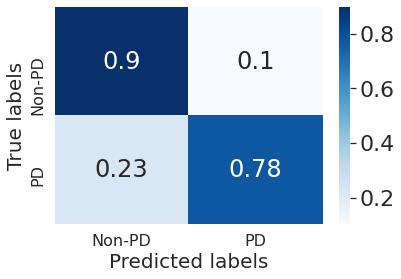

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       195
           1       0.82      0.81      0.81       120

    accuracy                           0.86       315
   macro avg       0.85      0.85      0.85       315
weighted avg       0.86      0.86      0.86       315
 

Confusion Matrix:  [[173  22]
 [ 23  97]]


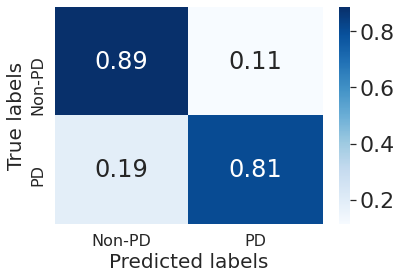

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       195
           1       0.79      0.70      0.74       120

    accuracy                           0.81       315
   macro avg       0.81      0.79      0.80       315
weighted avg       0.81      0.81      0.81       315
 

Confusion Matrix:  [[172  23]
 [ 36  84]]


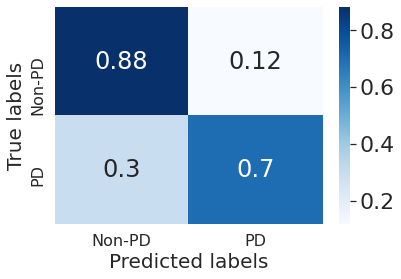

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       194
           1       0.78      0.68      0.73       120

    accuracy                           0.81       314
   macro avg       0.80      0.78      0.79       314
weighted avg       0.80      0.81      0.80       314
 

Confusion Matrix:  [[171  23]
 [ 38  82]]


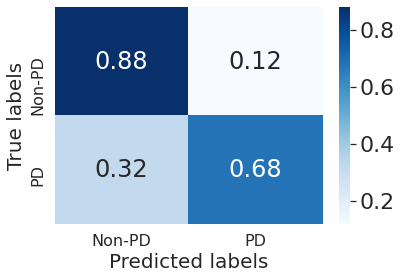

Random Forest Precision Score:  [0.85106, 0.82301, 0.81513, 0.78505, 0.78095]  |Average Precision Score:  0.81104
Random Forest Recall Score:  [0.66667, 0.775, 0.80833, 0.7, 0.68333]  |Average Recall Score:  0.726666
Random Forest AUC Score:  [0.79744, 0.83622, 0.84776, 0.79103, 0.78239]  |Average AUC Score:  0.810968
Random Forest F1 Score:  [0.74766, 0.79828, 0.81172, 0.74009, 0.72889]  |Average F1 Score:  0.765328
Random Forest MCC Score:  [0.63135, 0.68084, 0.69665, 0.59682, 0.5817]  |Average MCC Score:  0.637472


In [0]:
clfRFnew = model(dfAfter,RandomForestClassifier(random_state=351),"Random Forest")

## SVM Classfier 

      median        var    skewness  ...  meanWidth  numTrueSpikes  fault
937      0.0   0.003133  -17.435420  ...   2.187500             16      0
0        0.0   0.242051   -9.929521  ...   3.083333            204      1
1        0.0   0.036587   -9.210680  ...   2.723404             94      1
2        0.0   0.258717    2.670135  ...   3.356481            216      1
1497     0.0  15.313045   -0.226941  ...   7.345479            741      0
...      ...        ...         ...  ...        ...            ...    ...
1496     0.0   0.001693   -0.035624  ...   0.000000              0      0
1150     0.0   0.117272  -20.642137  ...   3.377358             53      0
1570     0.0   0.548200   19.221711  ...   3.505618             89      0
1358     0.0   0.002997 -113.751897  ...   2.000000             11      0
1247     0.0   3.474154   -2.169522  ...   5.688249            834      0

[1574 rows x 9 columns]
Running fold: 1
Classification report 
               precision    recall  f1-score   s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


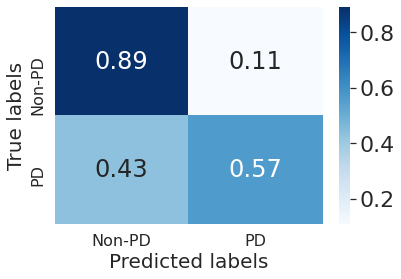

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       195
           1       0.75      0.57      0.65       120

    accuracy                           0.77       315
   macro avg       0.76      0.73      0.74       315
weighted avg       0.76      0.77      0.76       315
 

Confusion Matrix:  [[172  23]
 [ 51  69]]


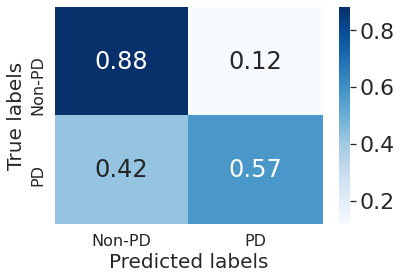

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       195
           1       0.77      0.63      0.69       120

    accuracy                           0.79       315
   macro avg       0.78      0.76      0.77       315
weighted avg       0.79      0.79      0.78       315
 

Confusion Matrix:  [[172  23]
 [ 44  76]]


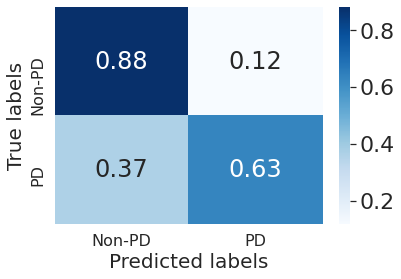

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       195
           1       0.77      0.64      0.70       120

    accuracy                           0.79       315
   macro avg       0.79      0.76      0.77       315
weighted avg       0.79      0.79      0.79       315
 

Confusion Matrix:  [[172  23]
 [ 43  77]]


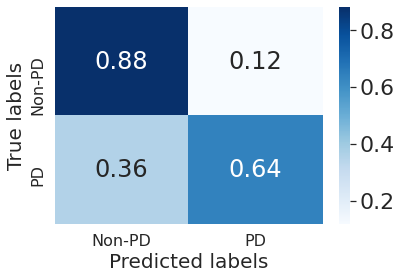

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       194
           1       0.65      0.47      0.54       120

    accuracy                           0.70       314
   macro avg       0.69      0.66      0.66       314
weighted avg       0.69      0.70      0.69       314
 

Confusion Matrix:  [[164  30]
 [ 64  56]]


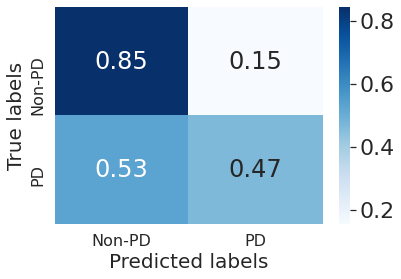

SVM Precision Score:  [0.76404, 0.75, 0.76768, 0.77, 0.65116]  |Average Precision Score:  0.740576
SVM Recall Score:  [0.56667, 0.575, 0.63333, 0.64167, 0.46667]  |Average Recall Score:  0.576668
SVM AUC Score:  [0.72949, 0.72853, 0.75769, 0.76186, 0.65601]  |Average AUC Score:  0.726716
SVM F1 Score:  [0.65072, 0.65094, 0.69406, 0.7, 0.54369]  |Average F1 Score:  0.647882
SVM MCC Score:  [0.49505, 0.48812, 0.53913, 0.54637, 0.33999]  |Average MCC Score:  0.481732


In [0]:
from sklearn import svm
svmClf = model(dfAfter,svm.SVC(random_state=351), "SVM")

## LightGBM


      median        var    skewness  ...  meanWidth  numTrueSpikes  fault
937      0.0   0.003133  -17.435420  ...   2.187500             16      0
0        0.0   0.242051   -9.929521  ...   3.083333            204      1
1        0.0   0.036587   -9.210680  ...   2.723404             94      1
2        0.0   0.258717    2.670135  ...   3.356481            216      1
1497     0.0  15.313045   -0.226941  ...   7.345479            741      0
...      ...        ...         ...  ...        ...            ...    ...
1496     0.0   0.001693   -0.035624  ...   0.000000              0      0
1150     0.0   0.117272  -20.642137  ...   3.377358             53      0
1570     0.0   0.548200   19.221711  ...   3.505618             89      0
1358     0.0   0.002997 -113.751897  ...   2.000000             11      0
1247     0.0   3.474154   -2.169522  ...   5.688249            834      0

[1574 rows x 9 columns]
Running fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Classification report 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       195
           1       0.82      0.68      0.74       120

    accuracy                           0.82       315
   macro avg       0.82      0.79      0.80       315
weighted avg       0.82      0.82      0.81       315
 

Confusion Matrix:  [[177  18]
 [ 39  81]]


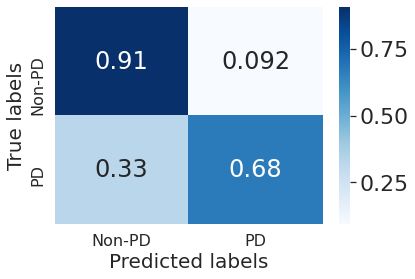

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       195
           1       0.75      0.77      0.76       120

    accuracy                           0.81       315
   macro avg       0.80      0.80      0.80       315
weighted avg       0.81      0.81      0.81       315
 

Confusion Matrix:  [[164  31]
 [ 28  92]]


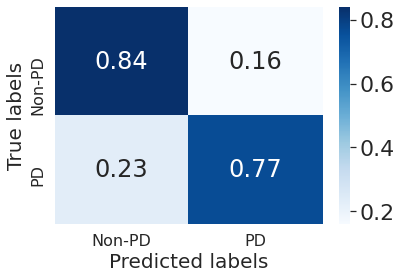

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       195
           1       0.83      0.80      0.82       120

    accuracy                           0.86       315
   macro avg       0.86      0.85      0.85       315
weighted avg       0.86      0.86      0.86       315
 

Confusion Matrix:  [[176  19]
 [ 24  96]]


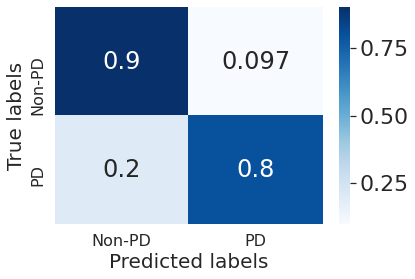

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       195
           1       0.79      0.75      0.77       120

    accuracy                           0.83       315
   macro avg       0.82      0.81      0.82       315
weighted avg       0.83      0.83      0.83       315
 

Confusion Matrix:  [[171  24]
 [ 30  90]]


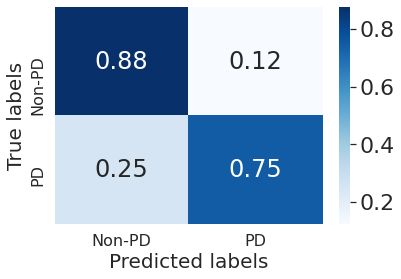

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       194
           1       0.76      0.68      0.72       120

    accuracy                           0.80       314
   macro avg       0.79      0.77      0.78       314
weighted avg       0.79      0.80      0.79       314
 

Confusion Matrix:  [[168  26]
 [ 38  82]]


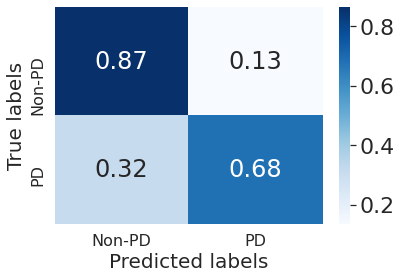

LGBM Precision Score:  [0.81818, 0.74797, 0.83478, 0.78947, 0.75926]  |Average Precision Score:  0.789932
LGBM Recall Score:  [0.675, 0.76667, 0.8, 0.75, 0.68333]  |Average Recall Score:  0.735
LGBM AUC Score:  [0.79135, 0.80385, 0.85128, 0.81346, 0.77466]  |Average AUC Score:  0.80692
LGBM F1 Score:  [0.73973, 0.7572, 0.81702, 0.76923, 0.7193]  |Average F1 Score:  0.760496
LGBM MCC Score:  [0.60954, 0.60491, 0.70865, 0.63354, 0.56191]  |Average MCC Score:  0.62371


In [0]:
from lightgbm import LGBMClassifier
lgbmClf = model(dfAfter,LGBMClassifier(random_state=351), "LGBM")

## Logistic Regression



      median        var    skewness  ...  meanWidth  numTrueSpikes  fault
937      0.0   0.003133  -17.435420  ...   2.187500             16      0
0        0.0   0.242051   -9.929521  ...   3.083333            204      1
1        0.0   0.036587   -9.210680  ...   2.723404             94      1
2        0.0   0.258717    2.670135  ...   3.356481            216      1
1497     0.0  15.313045   -0.226941  ...   7.345479            741      0
...      ...        ...         ...  ...        ...            ...    ...
1496     0.0   0.001693   -0.035624  ...   0.000000              0      0
1150     0.0   0.117272  -20.642137  ...   3.377358             53      0
1570     0.0   0.548200   19.221711  ...   3.505618             89      0
1358     0.0   0.002997 -113.751897  ...   2.000000             11      0
1247     0.0   3.474154   -2.169522  ...   5.688249            834      0

[1574 rows x 9 columns]
Running fold: 1
Classification report 
               precision    recall  f1-score   s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


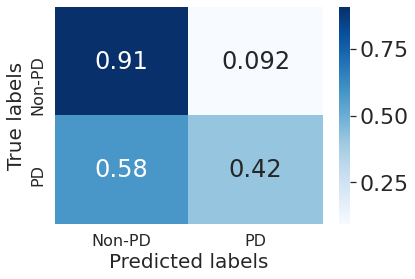

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       195
           1       0.79      0.47      0.59       120

    accuracy                           0.75       315
   macro avg       0.76      0.69      0.70       315
weighted avg       0.76      0.75      0.73       315
 

Confusion Matrix:  [[180  15]
 [ 64  56]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


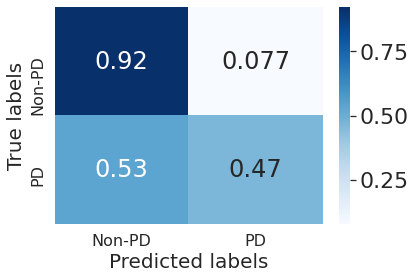

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.76      0.90      0.82       195
           1       0.76      0.53      0.63       120

    accuracy                           0.76       315
   macro avg       0.76      0.72      0.72       315
weighted avg       0.76      0.76      0.75       315
 

Confusion Matrix:  [[175  20]
 [ 56  64]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


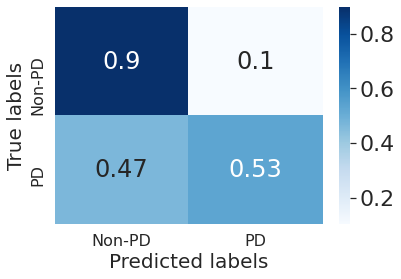

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.75      0.91      0.82       195
           1       0.78      0.52      0.62       120

    accuracy                           0.76       315
   macro avg       0.76      0.71      0.72       315
weighted avg       0.76      0.76      0.75       315
 

Confusion Matrix:  [[177  18]
 [ 58  62]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


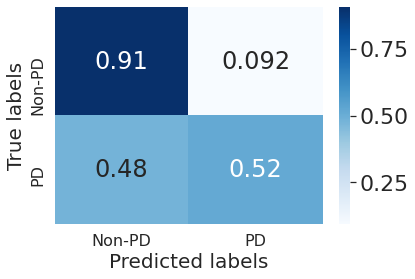

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.72      0.90      0.80       194
           1       0.73      0.43      0.54       120

    accuracy                           0.72       314
   macro avg       0.73      0.67      0.67       314
weighted avg       0.72      0.72      0.70       314
 

Confusion Matrix:  [[175  19]
 [ 68  52]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


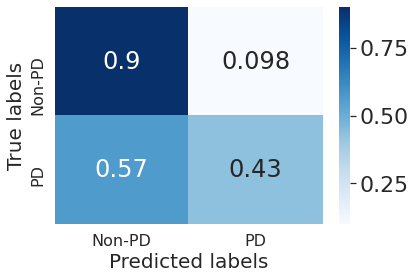

Logistic Regression Precision Score:  [0.73529, 0.78873, 0.7619, 0.775, 0.73239]  |Average Precision Score:  0.7586620000000001
Logistic Regression Recall Score:  [0.41667, 0.46667, 0.53333, 0.51667, 0.43333]  |Average Recall Score:  0.473334
Logistic Regression AUC Score:  [0.66218, 0.69487, 0.71538, 0.71218, 0.6677]  |Average AUC Score:  0.690462
Logistic Regression F1 Score:  [0.53191, 0.58639, 0.62745, 0.62, 0.5445]  |Average F1 Score:  0.58205
Logistic Regression MCC Score:  [0.38285, 0.45296, 0.47305, 0.47344, 0.3896]  |Average MCC Score:  0.43438


In [0]:
from sklearn.linear_model import LogisticRegression
LGClf = model(dfAfter,LogisticRegression(C=1e5,random_state=351),"Logistic Regression")

#Hyperparameter Tuning

Hyperparameter tuning was done for the ensemble models to hopefully output best hyperparameters to train this dataset

In [0]:
#Import Libraries and report fuction
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [0]:
X = dfAfter.iloc[:,0:-1]
X = X.values
y = dfAfter.iloc[:,-1:]
y = y.values


In [0]:
#Gridsearch for Random Forest Classifier 


# use a full grid over all parameters
param_gridRF = {'n_estimators': [100,200,500],
              'criterion': ["gini","entropy"],
              'min_samples_split': list(range(2,11,2))}


grid_search = GridSearchCV(clfRFnew, param_grid=param_gridRF, cv=5)
start = time()
grid_search.fit(X,y.ravel())

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 117.82 seconds for 30 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.834 (std: 0.021)
Parameters: {'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.833 (std: 0.017)
Parameters: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.833 (std: 0.019)
Parameters: {'criterion': 'entropy', 'min_samples_split': 6, 'n_estimators': 500}



In [0]:
#Gridsearch for LightGBM

# use a full grid over all parameters
param_gridLGBM = {'n_estimators': [100,200,500],
               'num_leaves': [31, 50, 100],
                'reg_alpha': [0,0.5,1],
                'reg_lambda': [0,0.5,1],
                'min_child_samples': [2,4,8,10,20]
                 }

grid_search = GridSearchCV(lgbmClf, param_grid=param_gridLGBM, cv=5)
start = time()
grid_search.fit(X,y.ravel())

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 1848.07 seconds for 405 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.839 (std: 0.019)
Parameters: {'min_child_samples': 2, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0}

Model with rank: 2
Mean validation score: 0.838 (std: 0.016)
Parameters: {'min_child_samples': 4, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 1, 'reg_lambda': 0.5}

Model with rank: 3
Mean validation score: 0.838 (std: 0.022)
Parameters: {'min_child_samples': 4, 'n_estimators': 200, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 1}



# Final Model

Final model that was built after hyperparameter tuning, results should show best model

      median        var    skewness  ...  meanWidth  numTrueSpikes  fault
937      0.0   0.003133  -17.435420  ...   2.187500             16      0
0        0.0   0.242051   -9.929521  ...   3.083333            204      1
1        0.0   0.036587   -9.210680  ...   2.723404             94      1
2        0.0   0.258717    2.670135  ...   3.356481            216      1
1497     0.0  15.313045   -0.226941  ...   7.345479            741      0
...      ...        ...         ...  ...        ...            ...    ...
1496     0.0   0.001693   -0.035624  ...   0.000000              0      0
1150     0.0   0.117272  -20.642137  ...   3.377358             53      0
1570     0.0   0.548200   19.221711  ...   3.505618             89      0
1358     0.0   0.002997 -113.751897  ...   2.000000             11      0
1247     0.0   3.474154   -2.169522  ...   5.688249            834      0

[1574 rows x 9 columns]
Running fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Classification report 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       195
           1       0.85      0.67      0.75       120

    accuracy                           0.83       315
   macro avg       0.84      0.80      0.81       315
weighted avg       0.83      0.83      0.82       315
 

Confusion Matrix:  [[181  14]
 [ 40  80]]


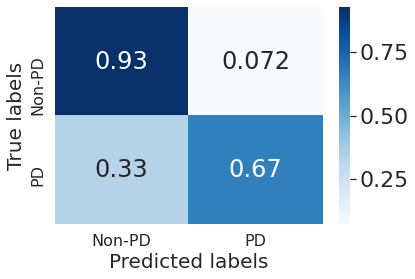

Running fold: 2
Classification report 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       195
           1       0.80      0.76      0.78       120

    accuracy                           0.83       315
   macro avg       0.83      0.82      0.82       315
weighted avg       0.83      0.83      0.83       315
 

Confusion Matrix:  [[172  23]
 [ 29  91]]


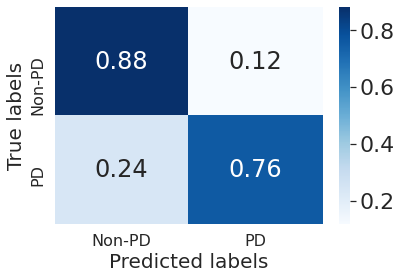

Running fold: 3
Classification report 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       195
           1       0.85      0.82      0.84       120

    accuracy                           0.88       315
   macro avg       0.87      0.87      0.87       315
weighted avg       0.88      0.88      0.88       315
 

Confusion Matrix:  [[177  18]
 [ 21  99]]


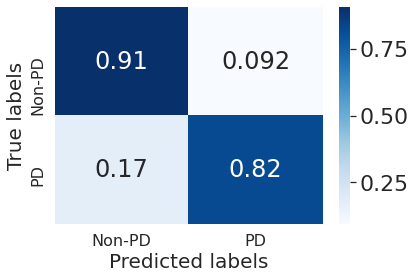

Running fold: 4
Classification report 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       195
           1       0.79      0.74      0.77       120

    accuracy                           0.83       315
   macro avg       0.82      0.81      0.82       315
weighted avg       0.83      0.83      0.83       315
 

Confusion Matrix:  [[172  23]
 [ 31  89]]


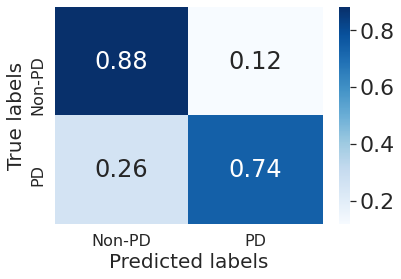

Running fold: 5
Classification report 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       194
           1       0.79      0.74      0.76       120

    accuracy                           0.82       314
   macro avg       0.82      0.81      0.81       314
weighted avg       0.82      0.82      0.82       314
 

Confusion Matrix:  [[170  24]
 [ 31  89]]


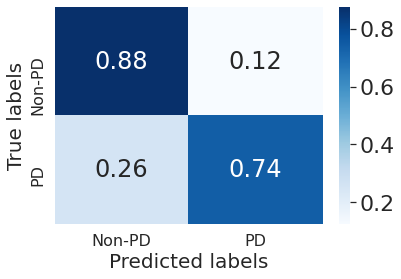

LGBM Tuned Precision Score:  [0.85106, 0.79825, 0.84615, 0.79464, 0.78761]  |Average Precision Score:  0.815542
LGBM Tuned Recall Score:  [0.66667, 0.75833, 0.825, 0.74167, 0.74167]  |Average Recall Score:  0.746668
LGBM Tuned AUC Score:  [0.79744, 0.82019, 0.86635, 0.81186, 0.80898]  |Average AUC Score:  0.820964
LGBM Tuned F1 Score:  [0.74766, 0.77778, 0.83544, 0.76724, 0.76395]  |Average F1 Score:  0.778414
LGBM Tuned MCC Score:  [0.63135, 0.64714, 0.73638, 0.63276, 0.62562]  |Average MCC Score:  0.65465


In [0]:
from lightgbm import LGBMClassifier
lgbmClf2 = model(dfAfter,LGBMClassifier(random_state=351,min_child_samples=2,n_estimators=100, num_leaves = 31, reg_alpha=0.5), "LGBM Tuned")